In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Getting started with JAX and NumPyro

From [JAX Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html):
> JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.

From [Getting Started with NumPyro](https://num.pyro.ai/en/stable/getting_started.html):
> NumPyro is a lightweight probabilistic programming library that provides a NumPy backend for Pyro. We rely on JAX for automatic differentiation and JIT compilation to GPU / CPU.

We'll also make use of [ArviZ](https://python.arviz.org/en/stable/) for useful plots:
> ArviZ is a Python package for exploratory analysis of Bayesian models. It serves as a backend-agnostic tool for diagnosing and visualizing Bayesian inference.

## Installation

If you load this repository in codespace everything will already be installed.  If you're working on a local machine, in most cases a simple
```bash
pip install numpyro arviz
```
will (hopefully) do the trick.

In [2]:
from jax import random
import jax.numpy as jnp
import numpyro.distributions as dist

Let's start with drawing some samples from a Gaussian distribution.  First let's read the docs for the implementation of the normal distribution.

In [3]:
dist.Normal?

Init signature: dist.Normal(loc=0.0, scale=1.0, *, validate_args=None)
Docstring:     
Base class for probability distributions in NumPyro. The design largely
follows from :mod:`torch.distributions`.

:param batch_shape: The batch shape for the distribution. This designates
    independent (possibly non-identical) dimensions of a sample from the
    distribution. This is fixed for a distribution instance and is inferred
    from the shape of the distribution parameters.
:param event_shape: The event shape for the distribution. This designates
    the dependent dimensions of a sample from the distribution. These are
    collapsed when we evaluate the log probability density of a batch of
    samples using `.log_prob`.
:param validate_args: Whether to enable validation of distribution
    parameters and arguments to `.log_prob` method.

As an example:

.. doctest::

   >>> import jax.numpy as jnp
   >>> import numpyro.distributions as dist
   >>> d = dist.Dirichlet(jnp.ones((2, 3, 4)))
 

...and for the `.sample()` method of the distribution object.

In [4]:
rv = dist.Normal(0, 1)
rv.sample?

Signature: rv.sample(key, sample_shape=())
Docstring:
Returns a sample from the distribution having shape given by
`sample_shape + batch_shape + event_shape`. Note that when `sample_shape` is non-empty,
leading dimensions (of size `sample_shape`) of the returned sample will
be filled with iid draws from the distribution instance.

:param jax.random.PRNGKey key: the rng_key key to be used for the distribution.
:param tuple sample_shape: the sample shape for the distribution.
:return: an array of shape `sample_shape + batch_shape + event_shape`
:rtype: numpy.ndarray
File:      ~/miniforge3/envs/comp-phys/lib/python3.11/site-packages/numpyro/distributions/continuous.py
Type:      method

One change off the bat when working with `NumPyro` and `JAX` is the need to explicitly manage the random number generator (RNG).  Let's create an RNG key and generate a 1-D array of 10,000 samples from the distribution. 

In [5]:
rng_key = random.PRNGKey(0)
samples = rv.sample(rng_key, (10000,))

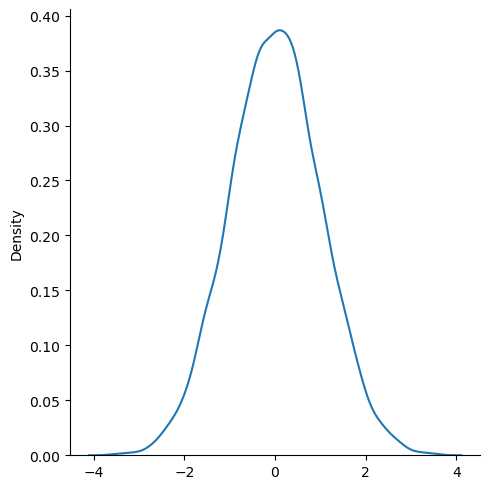

In [6]:
sns.displot(samples, kind='kde');

## Inference w/ NumPyro

The real power of `NumPyro` shines when we use it to conduct inference.  Let's generate some synthetic 1-D data from a normal distribution, then construct a forward model of a Gaussian distribution to describe and fit to that data.

In [7]:
import numpyro
import arviz as az  # for plotting and diagnostics

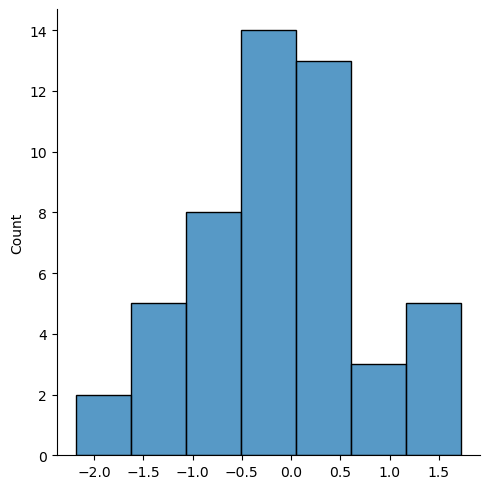

In [8]:
data = dist.Normal().sample(random.PRNGKey(0), (50,))
sns.displot(data)

Models are constructed as functions, whose arguments provide a means to specify data, specify assumptions, etc. Within the function we establish model parameters (the things we want to infer) by defining their **prior distributions** (what we "know" about them before collecting data, which is often "nothing").  We'll use a uniform prior for the mean of the Gaussian distribution (let's say from -10 to 10), and a half-normal distribution with a standard deviation of 10).  The last thing to define is the **likelihood**, which is where we establish the probabilistic description of the data and provide any observations.

In [9]:
def model(xdata=None):
    # model parameters and their priors
    μ =  numpyro.sample("μ", dist.Uniform(low=-10, high=10))
    σ = numpyro.sample("σ", dist.HalfNormal(scale=10))

    # Likelihood: the probabilistic description of the data, and observations
    obs = numpyro.sample("obs", dist.Normal(μ, σ), obs=xdata)

In [10]:
from numpyro import infer # where MCMC routines live

In [11]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

First we construct a "kernel", which describes _how_ an MCMC chain is updated.  We'll use the No-U-Turn sampler (NUTS), a Hamiltonian-MC-based sampler.

In [12]:
kernel = infer.NUTS(model)

Now let's construct an MCMC object using that kernel, specifying that we'll use 1000 steps to tune the sampler followed by another 5000 steps that we'll use to estimate the posterior distribution.

In [13]:
num_samples = 5000
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=num_samples)

Now that we've constructed the MCMC object, it's time to run it.  Now is when we plug in any arguments for the model, in this case, just the data.

In [14]:
mcmc.run(rng_key_, xdata=data)

sample: 100%|██████████| 6000/6000 [00:03<00:00, 1964.79it/s, 7 steps of size 8.78e-01. acc. prob=0.91] 


We can use `.print_summary()` to print some summary statistics

In [15]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         μ     -0.12      0.13     -0.12     -0.32      0.09   4984.26      1.00
         σ      0.89      0.09      0.88      0.73      1.03   3049.84      1.00

Number of divergences: 0


and extract the samples

In [16]:
samples = mcmc.get_samples()
samples

{'μ': Array([-0.09684026, -0.12650669, -0.0343436 , ..., -0.11810899,
        -0.125767  , -0.252133  ], dtype=float32),
 'σ': Array([0.9706302 , 0.7456488 , 0.7748342 , ..., 0.78693384, 0.752663  ,
        0.88980746], dtype=float32)}

Trace plots are a very useful diagnostic tool, giving us a fairly comprehensive picture of how the chain explored parameter space, and what the marginal (i.e., 1-D) posterior distributions for each parameter look like.

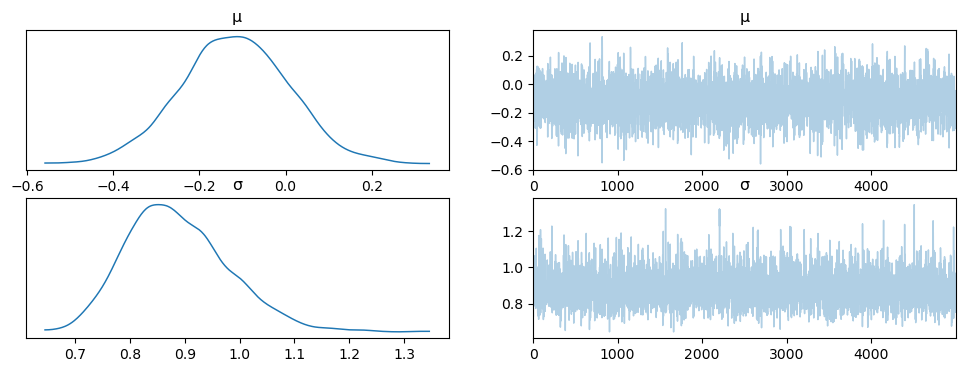

In [17]:
az.plot_trace(mcmc);

Finally, let's choose some samples from the chain (at random) reconstruct the normal distribution they correspond to, and compare them to the data.

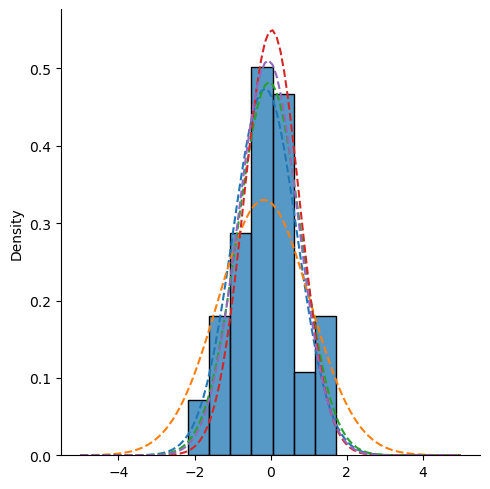

In [18]:
sns.displot(data, stat='density')
x = jnp.linspace(-5, 5, 100)

for i in random.choice(rng_key, num_samples, (5,)):
    plt.plot(
        x,
        jnp.exp(dist.Normal(samples['μ'][i],
                            samples['σ'][i]).log_prob(x)),
        ls='--')

This gives us a sense of our uncertainty in the underlying distribution.  Let's plot a bunch more to make this clearer.

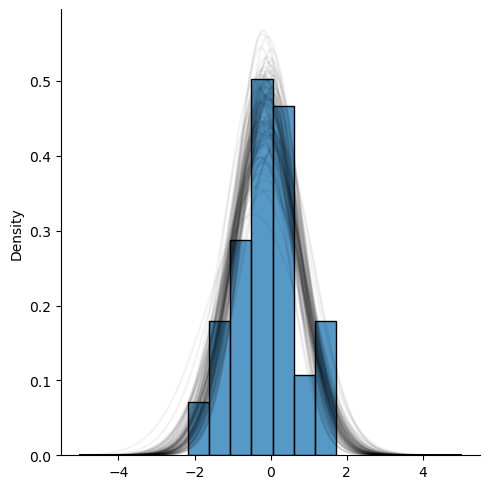

In [19]:
sns.displot(data, stat='density')

for i in random.choice(rng_key, num_samples, (100,)):
    plt.plot(
        x,
        jnp.exp(dist.Normal(samples['μ'][i],
                            samples['σ'][i]).log_prob(x)),
        color='k',
        alpha=0.05)